In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn.functional as F
import torchvision
import os
from torch import nn
from tqdm import tqdm

In [4]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [5]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Домашнее задание

Обучите сверточную нейронную сеть на датасете MNIST, взяв любой другой оптимизатор (кроме SGD) и любую другую функцию ошибки (кроме cross-entropy loss). Попробуйте поварьировать параметры: кол-во ядер, `kernel_size` и побить текущий бейзлайн в `0.9747`. Выведите количество обучаемых параметров.    
Какого качества удалось достичь? Попробуйте залоггировать Ваши результаты - построить графики того, как менялись метрики качества (accuracy, loss) с течением эпох, включить логгирование, сравнить результаты между собой при разных параметрах.

Любые дополнительные улучшения (как по методам, так и по коду пайплайна) приветствуются!

*Цель:* выработать навык обучения нейронных сетей (в частности сверточных) на основе средств PyTorch, начиная от загрузки датасетами и заканчивая выводами результатов, их логгированием, сравнением и анализом.

In [6]:
seed_everything(42)

mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

In [8]:

def train(
    model,
    optimizer,
    loss_fn,  
    n_epochs=5,
    train_dataloader=None,
    val_dataloader=None
):
    train_acc_history = []
    val_acc_history = []
    val_loss_history = []

    for epoch in range(n_epochs):
        model.train()
        epoch_train_correct = 0
        epoch_train_total = 0

        for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{n_epochs} (Train)", leave=False):
            optimizer.zero_grad()
            y_pred = model(x_train)
            
            if loss_fn == F.binary_cross_entropy_with_logits:
                y_train_onehot = F.one_hot(y_train, num_classes=y_pred.size(1)).float()
                loss = loss_fn(y_pred, y_train_onehot)
            else:
                loss = loss_fn(y_pred, y_train)
                
            loss.backward()
            optimizer.step()

            if y_pred.dim() > 1 and y_pred.size(1) > 1:  
                preds = torch.argmax(y_pred, dim=1)
            else:  
                preds = (y_pred > 0.5).long().squeeze()

            epoch_train_correct += (preds == y_train).sum().item()
            epoch_train_total += y_train.size(0)

        train_acc = epoch_train_correct / epoch_train_total if epoch_train_total > 0 else 0
        train_acc_history.append(train_acc)

        model.eval()
        val_loss = []
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for x_val, y_val in tqdm(val_dataloader, desc="Validation", leave=False):
                y_pred = model(x_val)

                if loss_fn == F.binary_cross_entropy_with_logits:
                    y_val_onehot = F.one_hot(y_val, num_classes=10).float()
                    loss = loss_fn(y_pred, y_val_onehot)
                else:
                    loss = loss_fn(y_pred, y_val)
                
                val_loss.append(loss.item())

                if y_pred.dim() > 1 and y_pred.size(1) > 1:
                    preds = torch.argmax(y_pred, dim=1)
                else:
                    preds = (y_pred > 0.5).long().squeeze()

                val_correct += (preds == y_val).sum().item()
                val_total += y_val.size(0)

        avg_val_loss = np.mean(val_loss)
        val_acc = val_correct / val_total if val_total > 0 else 0

        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_acc)

        print(f'Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {avg_val_loss:.4f}')

    return {
        'train_acc': train_acc_history,
        'val_acc': val_acc_history,
        'val_loss': val_loss_history
    }

In [9]:

optimizers_config = [
    {'name': 'Adagrad', 'optimizer': lambda params: torch.optim.Adagrad(params, lr=0.01)},
    {'name': 'Adam', 'optimizer': lambda params: torch.optim.Adam(params, lr=0.001)},
    {'name': 'RMSprop', 'optimizer': lambda params: torch.optim.RMSprop(params, lr=0.001)},
    {'name': 'AdamW', 'optimizer': lambda params: torch.optim.AdamW(params, lr=0.001, weight_decay=0.01)},
]

loss_fn_config = [
     {'name': 'binary_cross_entropy_with_logits', 'loss_fn': F.binary_cross_entropy_with_logits},
    {'name': 'cross_entropy', 'loss_fn': F.cross_entropy},
]

results = {}

for opt_config in optimizers_config:
    for loss_config in loss_fn_config:
        print(f"\n Training with {opt_config['name']} and {loss_config['name']}")
    
        model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),
            nn.Flatten(),
            nn.Linear(6*6*10, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
        optimizer = opt_config['optimizer'](model.parameters())
        loss_fn = loss_config['loss_fn']
        # 
        history = train(model, optimizer, loss_fn, n_epochs=5, train_dataloader=train_dataloader, val_dataloader=val_dataloader)
    
        results[opt_config['name'] + " and " + loss_config['name']] = history


 Training with Adagrad and binary_cross_entropy_with_logits


Epoch 1: Train Acc: 0.9325, Val Acc: 0.9694, Val Loss: 0.0230


Epoch 2: Train Acc: 0.9723, Val Acc: 0.9759, Val Loss: 0.0178


Epoch 3: Train Acc: 0.9776, Val Acc: 0.9799, Val Loss: 0.0148


Epoch 4: Train Acc: 0.9802, Val Acc: 0.9813, Val Loss: 0.0135


Epoch 5: Train Acc: 0.9817, Val Acc: 0.9819, Val Loss: 0.0127

 Training with Adagrad and cross_entropy


Epoch 1: Train Acc: 0.9396, Val Acc: 0.9717, Val Loss: 0.0981


Epoch 2: Train Acc: 0.9722, Val Acc: 0.9777, Val Loss: 0.0789


Epoch 3: Train Acc: 0.9777, Val Acc: 0.9800, Val Loss: 0.0643


Epoch 4: Train Acc: 0.9805, Val Acc: 0.9818, Val Loss: 0.0578


Epoch 5: Train Acc: 0.9826, Val Acc: 0.9827, Val Loss: 0.0519

 Training with Adam and binary_cross_entropy_with_logits


Epoch 1: Train Acc: 0.9109, Val Acc: 0.9662, Val Loss: 0.0235


Epoch 2: Train Acc: 0.9751, Val Acc: 0.9815, Val Loss: 0.0131


Epoch 3: Train Acc: 0.9825, Val Acc: 0.9835, Val Loss: 0.0112


Epoch 4: Train Acc: 0.9856, Val Acc: 0.9875, Val Loss: 0.0092


Epoch 5: Train Acc: 0.9883, Val Acc: 0.9852, Val Loss: 0.0100

 Training with Adam and cross_entropy


Epoch 1: Train Acc: 0.9367, Val Acc: 0.9751, Val Loss: 0.0783


Epoch 2: Train Acc: 0.9776, Val Acc: 0.9836, Val Loss: 0.0499


Epoch 3: Train Acc: 0.9829, Val Acc: 0.9830, Val Loss: 0.0473


Epoch 4: Train Acc: 0.9869, Val Acc: 0.9830, Val Loss: 0.0488


Epoch 5: Train Acc: 0.9888, Val Acc: 0.9861, Val Loss: 0.0431

 Training with RMSprop and binary_cross_entropy_with_logits


Epoch 1: Train Acc: 0.9401, Val Acc: 0.9698, Val Loss: 0.0211


Epoch 2: Train Acc: 0.9781, Val Acc: 0.9821, Val Loss: 0.0110


Epoch 3: Train Acc: 0.9843, Val Acc: 0.9858, Val Loss: 0.0096


Epoch 4: Train Acc: 0.9876, Val Acc: 0.9848, Val Loss: 0.0093


Epoch 5: Train Acc: 0.9898, Val Acc: 0.9872, Val Loss: 0.0096

 Training with RMSprop and cross_entropy


Epoch 1: Train Acc: 0.9430, Val Acc: 0.9624, Val Loss: 0.1219


Epoch 2: Train Acc: 0.9775, Val Acc: 0.9845, Val Loss: 0.0483


Epoch 3: Train Acc: 0.9842, Val Acc: 0.9824, Val Loss: 0.0565


Epoch 4: Train Acc: 0.9870, Val Acc: 0.9863, Val Loss: 0.0429


Epoch 5: Train Acc: 0.9896, Val Acc: 0.9844, Val Loss: 0.0488

 Training with AdamW and binary_cross_entropy_with_logits


Epoch 1: Train Acc: 0.9092, Val Acc: 0.9722, Val Loss: 0.0197


Epoch 2: Train Acc: 0.9768, Val Acc: 0.9816, Val Loss: 0.0128


Epoch 3: Train Acc: 0.9827, Val Acc: 0.9854, Val Loss: 0.0105


Epoch 4: Train Acc: 0.9861, Val Acc: 0.9866, Val Loss: 0.0092


Epoch 5: Train Acc: 0.9884, Val Acc: 0.9881, Val Loss: 0.0086

 Training with AdamW and cross_entropy


Epoch 1: Train Acc: 0.9337, Val Acc: 0.9777, Val Loss: 0.0743


Epoch 2: Train Acc: 0.9773, Val Acc: 0.9818, Val Loss: 0.0594


Epoch 3: Train Acc: 0.9834, Val Acc: 0.9841, Val Loss: 0.0470


Epoch 4: Train Acc: 0.9860, Val Acc: 0.9839, Val Loss: 0.0531


Epoch 5: Train Acc: 0.9884, Val Acc: 0.9841, Val Loss: 0.0467


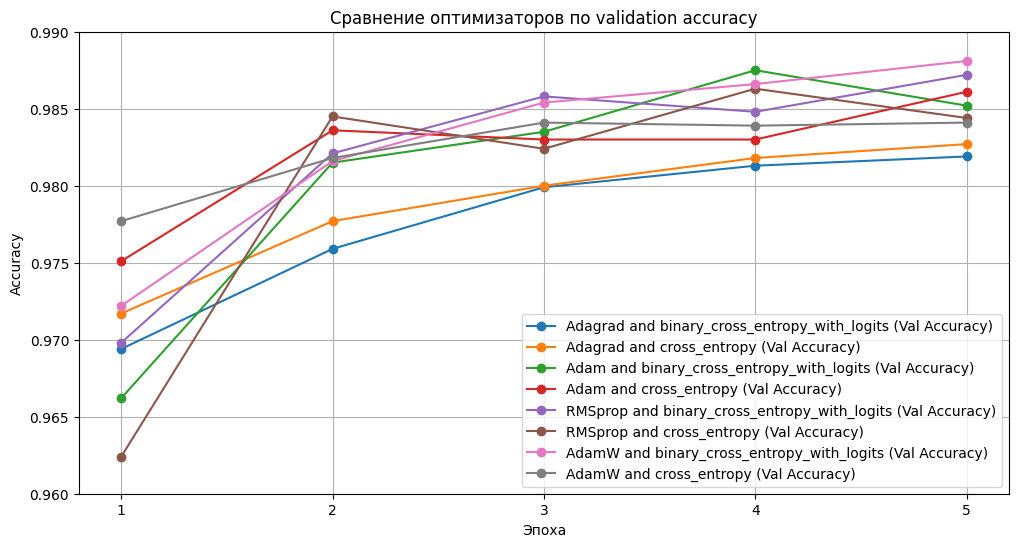

In [10]:
plt.figure(figsize=(12, 6))

for name, history in results.items():
    epochs = range(1, len(history['val_acc']) + 1)
    plt.plot(epochs, history['val_acc'], label=f'{name} (Val Accuracy)', marker='o')

plt.title('Сравнение оптимизаторов по validation accuracy')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(epochs)  
plt.ylim(0.96, 0.99)
plt.show()


# Сравнение оптимизаторов и функций потерь

На представленном графике показана динамика точности для различных комбинаций оптимизаторов и функций потерь при обучении модели 
График демонстрирует, что:

- Все модели достигают высокой точности (>97%) уже к 2-3 эпохе.
- **Adam** и **AdamW** с обеими функциями потерь (cross_entropy и binary_cross_entropy_with_logits) показывают лучшую стабильность и конечную точность (~0.985-0.988).
- **Adagrad** и **RMSprop** с `cross_entropy` начинают с более низкой точности, но постепенно улучшаются.
- Использование `binary_cross_entropy_with_logits` в сочетании с Adam/AdamW приводит к быстрой сходимости, хотя `cross_entropy` часто дает немного лучший финальный результат (зависит от сида и конечные значения могут отличаться)


## Вывод

Лучшие результаты показали **RMSprop** и **AdamW** с **binary_cross_entropy**, которые обеспечивают высокую точность и стабильную сходимость. В дальнейшем возьмем за оптимизатор **RMSprop**, а за функцию потерь **binary_cross_entropy** и попробуем подобрать параметры модели - kernel_size и out_channels



In [12]:

kernel_sizes = [1, 5, 9]
out_channels_list = [8, 16, 32, 64]

results = {}  
for ks in kernel_sizes:
    for oc in out_channels_list:
        print(f"Обучение модели: kernel_size={ks}, out_channels={oc}")

        H_conv = 28 - ks + 1
        H_pooled = H_conv // 4

        if H_conv % 4 != 0:
            continue

        model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=oc, kernel_size=ks),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),
            nn.Flatten(),
            nn.Linear(H_pooled * H_pooled * oc, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
        loss_fn = F.binary_cross_entropy_with_logits

        history = train(model=model,optimizer=optimizer,loss_fn=loss_fn,n_epochs=5,train_dataloader=train_dataloader,val_dataloader=val_dataloader )

        key = f"ks{ks}_oc{oc}"
        results[key] = {
            'history': history,
            'kernel_size': ks,
            'out_channels': oc,
            'final_val_acc': history['val_acc'][-1] if history['val_acc'] else 0,
            'final_val_loss': history['val_loss'][-1] if history['val_loss'] else float('inf')
        }

        print(f"Final Val Acc: {results[key]['final_val_acc']:.4f}")

Обучение модели: kernel_size=1, out_channels=8


Epoch 1: Train Acc: 0.7974, Val Acc: 0.8245, Val Loss: 0.0951


Epoch 2: Train Acc: 0.8591, Val Acc: 0.8678, Val Loss: 0.0729


Epoch 3: Train Acc: 0.8769, Val Acc: 0.8809, Val Loss: 0.0672


Epoch 4: Train Acc: 0.8876, Val Acc: 0.8899, Val Loss: 0.0635


Epoch 5: Train Acc: 0.8934, Val Acc: 0.8892, Val Loss: 0.0628
Final Val Acc: 0.8892
Обучение модели: kernel_size=1, out_channels=16


Epoch 1: Train Acc: 0.7684, Val Acc: 0.8366, Val Loss: 0.0931


Epoch 2: Train Acc: 0.8487, Val Acc: 0.8529, Val Loss: 0.0830


Epoch 3: Train Acc: 0.8705, Val Acc: 0.8793, Val Loss: 0.0705


Epoch 4: Train Acc: 0.8817, Val Acc: 0.8818, Val Loss: 0.0677


Epoch 5: Train Acc: 0.8879, Val Acc: 0.8901, Val Loss: 0.0634
Final Val Acc: 0.8901
Обучение модели: kernel_size=1, out_channels=32


Epoch 1: Train Acc: 0.7867, Val Acc: 0.8496, Val Loss: 0.0846


Epoch 2: Train Acc: 0.8582, Val Acc: 0.8745, Val Loss: 0.0722


Epoch 3: Train Acc: 0.8751, Val Acc: 0.8849, Val Loss: 0.0689


Epoch 4: Train Acc: 0.8847, Val Acc: 0.8911, Val Loss: 0.0637


Epoch 5: Train Acc: 0.8910, Val Acc: 0.8921, Val Loss: 0.0640
Final Val Acc: 0.8921
Обучение модели: kernel_size=1, out_channels=64


Epoch 1: Train Acc: 0.7765, Val Acc: 0.8231, Val Loss: 0.0967


Epoch 2: Train Acc: 0.8496, Val Acc: 0.8581, Val Loss: 0.0824


Epoch 3: Train Acc: 0.8683, Val Acc: 0.8763, Val Loss: 0.0737


Epoch 4: Train Acc: 0.8785, Val Acc: 0.8767, Val Loss: 0.0718


Epoch 5: Train Acc: 0.8860, Val Acc: 0.8717, Val Loss: 0.0790
Final Val Acc: 0.8717
Обучение модели: kernel_size=5, out_channels=8


Epoch 1: Train Acc: 0.9333, Val Acc: 0.9783, Val Loss: 0.0171


Epoch 2: Train Acc: 0.9780, Val Acc: 0.9827, Val Loss: 0.0122


Epoch 3: Train Acc: 0.9835, Val Acc: 0.9850, Val Loss: 0.0102


Epoch 4: Train Acc: 0.9867, Val Acc: 0.9873, Val Loss: 0.0090


Epoch 5: Train Acc: 0.9885, Val Acc: 0.9853, Val Loss: 0.0102
Final Val Acc: 0.9853
Обучение модели: kernel_size=5, out_channels=16


Epoch 1: Train Acc: 0.9407, Val Acc: 0.9812, Val Loss: 0.0148


Epoch 2: Train Acc: 0.9811, Val Acc: 0.9864, Val Loss: 0.0090


Epoch 3: Train Acc: 0.9865, Val Acc: 0.9857, Val Loss: 0.0091


Epoch 4: Train Acc: 0.9892, Val Acc: 0.9895, Val Loss: 0.0072


Epoch 5: Train Acc: 0.9911, Val Acc: 0.9884, Val Loss: 0.0075
Final Val Acc: 0.9884
Обучение модели: kernel_size=5, out_channels=32


Epoch 1: Train Acc: 0.9438, Val Acc: 0.9810, Val Loss: 0.0132


Epoch 2: Train Acc: 0.9826, Val Acc: 0.9592, Val Loss: 0.0277


Epoch 3: Train Acc: 0.9877, Val Acc: 0.9879, Val Loss: 0.0082


Epoch 4: Train Acc: 0.9894, Val Acc: 0.9901, Val Loss: 0.0075


Epoch 5: Train Acc: 0.9920, Val Acc: 0.9902, Val Loss: 0.0066
Final Val Acc: 0.9902
Обучение модели: kernel_size=5, out_channels=64


Epoch 1: Train Acc: 0.9427, Val Acc: 0.9771, Val Loss: 0.0184


Epoch 2: Train Acc: 0.9829, Val Acc: 0.9877, Val Loss: 0.0093


Epoch 3: Train Acc: 0.9877, Val Acc: 0.9877, Val Loss: 0.0085


Epoch 4: Train Acc: 0.9902, Val Acc: 0.9901, Val Loss: 0.0079


Epoch 5: Train Acc: 0.9919, Val Acc: 0.9881, Val Loss: 0.0076
Final Val Acc: 0.9881
Обучение модели: kernel_size=9, out_channels=8


Epoch 1: Train Acc: 0.9344, Val Acc: 0.9730, Val Loss: 0.0199


Epoch 2: Train Acc: 0.9772, Val Acc: 0.9841, Val Loss: 0.0115


Epoch 3: Train Acc: 0.9830, Val Acc: 0.9844, Val Loss: 0.0110


Epoch 4: Train Acc: 0.9860, Val Acc: 0.9861, Val Loss: 0.0096


Epoch 5: Train Acc: 0.9880, Val Acc: 0.9846, Val Loss: 0.0100
Final Val Acc: 0.9846
Обучение модели: kernel_size=9, out_channels=16


Epoch 1: Train Acc: 0.9485, Val Acc: 0.9687, Val Loss: 0.0224


Epoch 2: Train Acc: 0.9823, Val Acc: 0.9745, Val Loss: 0.0169


Epoch 3: Train Acc: 0.9871, Val Acc: 0.9850, Val Loss: 0.0108


Epoch 4: Train Acc: 0.9893, Val Acc: 0.9893, Val Loss: 0.0075


Epoch 5: Train Acc: 0.9910, Val Acc: 0.9905, Val Loss: 0.0065
Final Val Acc: 0.9905
Обучение модели: kernel_size=9, out_channels=32


Epoch 1: Train Acc: 0.9489, Val Acc: 0.9847, Val Loss: 0.0113


Epoch 2: Train Acc: 0.9834, Val Acc: 0.9878, Val Loss: 0.0080


Epoch 3: Train Acc: 0.9879, Val Acc: 0.9903, Val Loss: 0.0064


Epoch 4: Train Acc: 0.9902, Val Acc: 0.9902, Val Loss: 0.0065


Epoch 5: Train Acc: 0.9923, Val Acc: 0.9887, Val Loss: 0.0073
Final Val Acc: 0.9887
Обучение модели: kernel_size=9, out_channels=64


Epoch 1: Train Acc: 0.9454, Val Acc: 0.9816, Val Loss: 0.0115


Epoch 2: Train Acc: 0.9835, Val Acc: 0.9842, Val Loss: 0.0106


Epoch 3: Train Acc: 0.9882, Val Acc: 0.9834, Val Loss: 0.0121


Epoch 4: Train Acc: 0.9903, Val Acc: 0.9828, Val Loss: 0.0114


Epoch 5: Train Acc: 0.9923, Val Acc: 0.9903, Val Loss: 0.0066
Final Val Acc: 0.9903


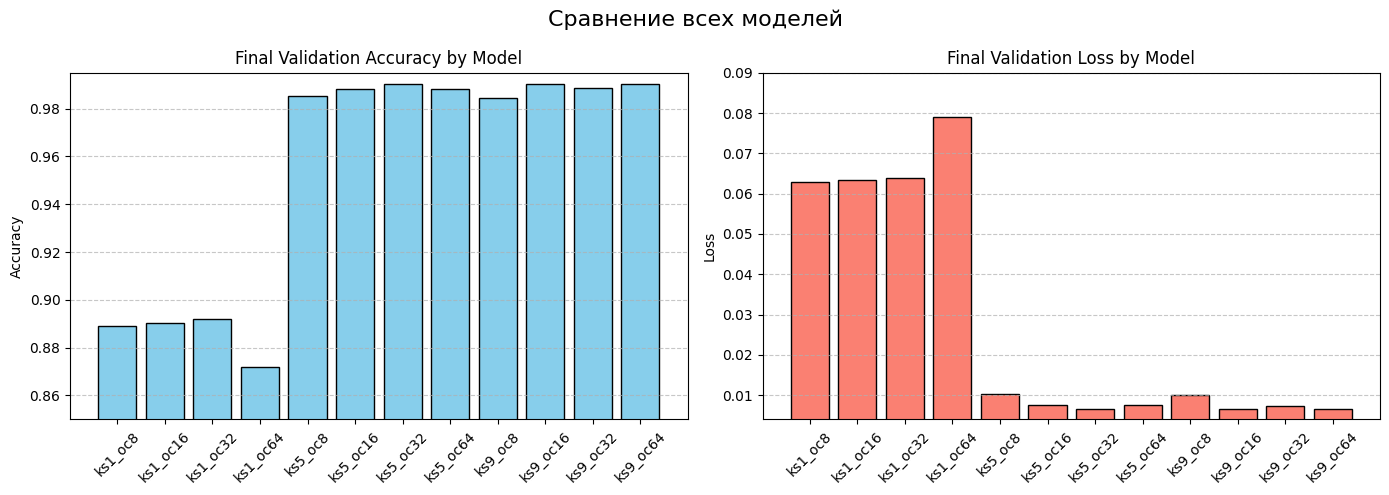

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Сравнение всех моделей', fontsize=16)


labels = []
final_accs = []
final_losses = []

for key, data in results.items():
    labels.append(key)
    final_accs.append(data['final_val_acc'])
    final_losses.append(data['final_val_loss'])

# Accuracy (Все)
axes[0].bar(labels, final_accs, color='skyblue', edgecolor='black')
axes[0].set_title('Final Validation Accuracy by Model')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0.85, 0.995)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Loss (Все)
axes[1].bar(labels, final_losses, color='salmon', edgecolor='black')
axes[1].set_title('Final Validation Loss by Model')
axes[1].set_ylabel('Loss')
axes[1].set_ylim(0.004, 0.09)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

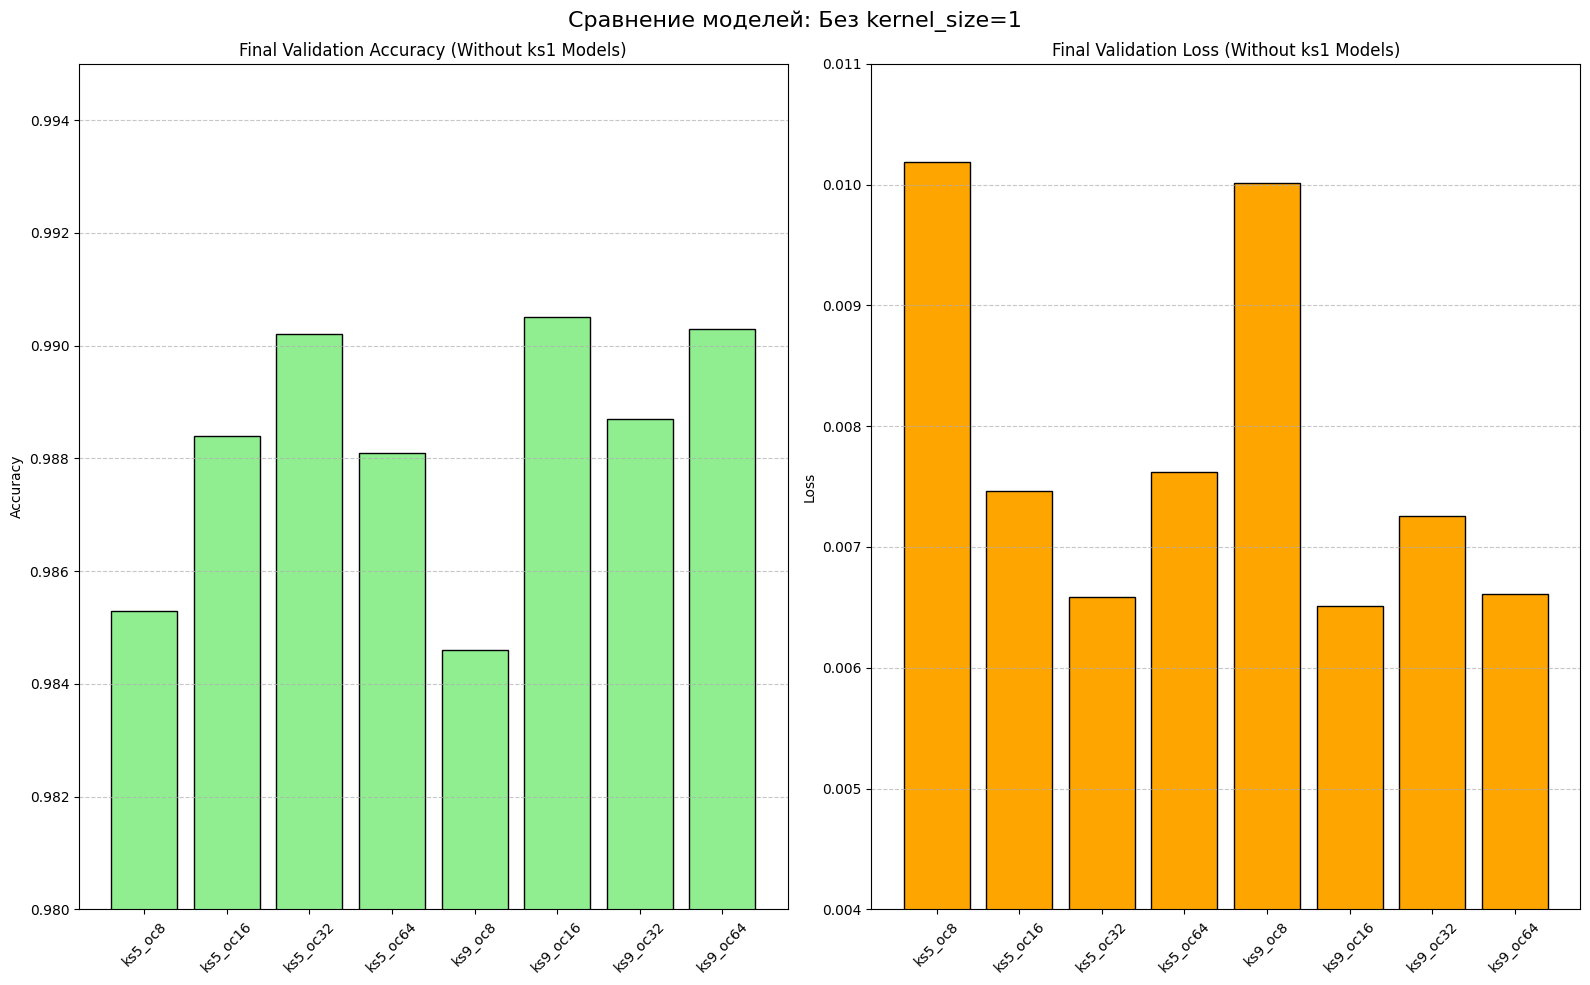

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 10))
fig.suptitle('Сравнение моделей: Без kernel_size=1', fontsize=16)


labels_filtered = []
final_accs_filtered = []
final_losses_filtered = []

for key, data in results.items():
    if not key.startswith("ks1"):  # ← Исключаем все, что начинается с "ks1"
        labels_filtered.append(key)
        final_accs_filtered.append(data['final_val_acc'])
        final_losses_filtered.append(data['final_val_loss'])

# Accuracy
axes[0].bar(labels_filtered, final_accs_filtered, color='lightgreen', edgecolor='black')
axes[0].set_title('Final Validation Accuracy (Without ks1 Models)')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0.98, 0.995)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Loss
axes[1].bar(labels_filtered, final_losses_filtered, color='orange', edgecolor='black')
axes[1].set_title('Final Validation Loss (Without ks1 Models)')
axes[1].set_ylabel('Loss')
axes[1].set_ylim(0.004, 0.011)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Анализ результатов экспериментов: влияние `kernel_size` и `out_channels` на качество модели

На представленных графиках показано сравнение моделей с разными значениями **`kernel_size`** (размер ядра свёртки) и **`out_channels`** (количество фильтров) на задаче классификации изображений

### Сравнение всех моделей (включая `ks1`)
- Модели с `kernel_size=1` демонстрируют значительно более низкую точность высокий loss
- Это связано с тем, что `kernel_size=1` эквивалентен полносвязному слою, короче он не извлекает локальные признаки, а просто комбинирует пиксели
- Такие модели теряют пространственную информацию и неэффективны для изображений

### Сравнение без `ks1` (только `ks3`, `ks5`, `ks9`)
- Все модели показывают высокую точность (**>0.98**) и низкий loss (**<0.01**)
- Лучшие результаты достигнуты при:
  - `ks5_oc32`: accuracy ~0.990, loss ~0.006
  - `ks9_oc16`: accuracy ~0.990, loss ~0.007
- Увеличение `out_channels` положительно влияет на точность, но при слишком большом числе фильтров может привести к переобучению

## Выводы

1. **`kernel_size=1` не подходит для извлечения признаков** - он не учитывает локальную структуру изображения
2. **Оптимальный размер ядра** - `5×5` или `9×9`, которые хорошо захватывают края, углы и текстуры
3. **Количество фильтров** должно быть достаточно большим (16-32), чтобы извлекать разнообразные признаки
4. **Лучшая комбинация**: `kernel_size=5`, `out_channels=32` обеспечивает максимальную точность и минимальный loss
## Итоговый результат - 0.9902